In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time

#data_location = Path('/data/users/tch14/pickled_data')
#figure_location = Path('/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Short Paper/figs')

data_location = Path('~/HPC_data/pickled_data').expanduser()

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


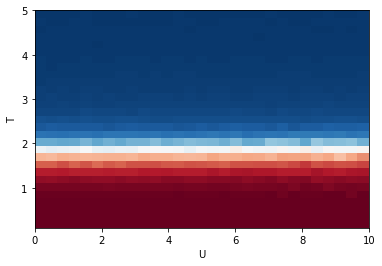

In [2]:
def TU_phase_diagram(ax):
    with open( data_location / 'TU_phase_data.pickle', 'rb') as file: 
        TU_data = pickle.load(file)   
    

    plot_binder = False
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    #TU_data.hints.Mf_moments == ('Ns', 'repeats', 'Us', 'Ts', 'moment', 'MCstep')
    M2 = TU_data.Mf_moments[-1, :, :, :, 2].mean(axis = (0)).T
    M4 = TU_data.Mf_moments[-1, :, :, :, 4].mean(axis = (0)).T
    Y = M2**2 / M4 if plot_binder else M2
    
    pcol = ax.pcolormesh(TU_data.Us, TU_data.Ts, Y, cmap="RdBu_r", norm = norm, linewidth=0, rasterized = True)
    #pcol.set_edgecolor('face')
    ax.set(ylabel = 'T', xlabel = 'U')
    
f, axes = plt.subplots(1,1, sharey = 'all', gridspec_kw = dict(wspace = 0.1))
TU_phase_diagram(axes)


In [3]:
with open( data_location / 'TU_phase_data.pickle', 'rb') as file: 
    TU_data = pickle.load(file) 
    
TU_data.keys()

dict_keys(['Mf_moments', 'sigma_Mf_moments', 'E_bins', 'IPR', 'DOS', 'total_jobs', 'Us', 'Ts', 'Ns', 'repeats', 'structure_names', 'parameters', 'MCMC_params', 'desc', 'structure_dims', 'hints', 'T'])

In [4]:
TU_data.hints.IPR, TU_data.IPR.shape

(('Ns', 'repeats', 'Us', 'Ts', 'energy index'), (6, 1, 30, 30, 2000))

128000.0
0.00421875


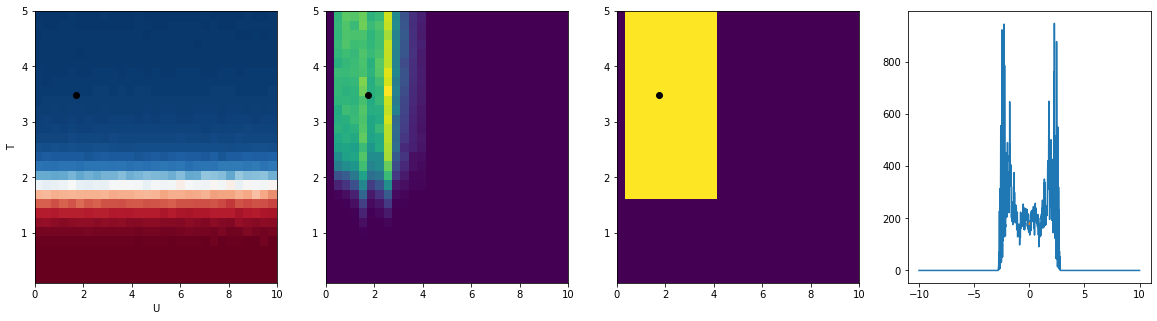

In [10]:
Ui = 5
Ti = 20


e = 0.01
ix = (-e < TU_data.E_bins[:-1] ) & (TU_data.E_bins[:-1] < e)

DOS = TU_data.DOS[-1, :, :, :, :].mean(axis = 0)
normalisation = DOS.sum(axis = -1)[0, 0]
print(normalisation)
percent_low_E_states = DOS[:, :, ix].sum(axis = -1) / normalisation

single = TU_data.DOS[-1, :, Ui, Ti, :].mean(axis = 0)

f, ax = plt.subplots(1,4, figsize = (20, 5), gridspec_kw = dict())

TU_phase_diagram(ax[0])
ax[1].pcolormesh(TU_data.Us, TU_data.Ts, percent_low_E_states.T, linewidth=0, rasterized = True)
ax[3].plot(TU_data.E_bins[:-1], single)

ax[0].plot([TU_data.Us[Ui],], [TU_data.Ts[Ti],], marker = 'o', color = 'k')
ax[1].plot([TU_data.Us[Ui],], [TU_data.Ts[Ti],], marker = 'o', color = 'k')
ax[2].plot([TU_data.Us[Ui],], [TU_data.Ts[Ti],], marker = 'o', color = 'k')


M2 = TU_data.Mf_moments[-1, :, :, :, 2].mean(axis = (0)).T
ax[2].pcolormesh(TU_data.Us, TU_data.Ts, (percent_low_E_states.T > 0) & (M2 < 0.7) , linewidth=0, rasterized = True)

single[~ix] = np.NaN
ax[3].plot(TU_data.E_bins[:-1], single)

percent_low_E_states = DOS[:, :, ix].sum(axis = -1) / normalisation
print(percent_low_E_states[Ui, Ti])

128000.0
[  0   0   0   0   0   0   0   0   0 -18 -18 -18 -18 -18 -18 -18 -18 -18
 -18 -18 -18 -18 -18 -18 -18 -18 -18 -18 -18 -18]


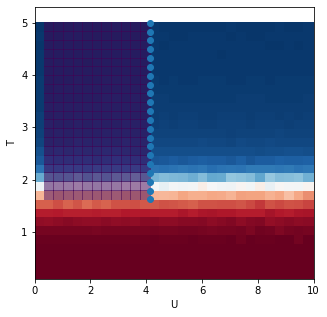

In [33]:
#the width of the energy bin to use
e = 0.01
#the indices of that energy bin into the data
ix = (-e < TU_data.E_bins[:-1] ) & (TU_data.E_bins[:-1] < e)

#the larges N DOS with a mean taken over the repeats axis
DOS = TU_data.DOS[-1, :, :, :, :].mean(axis = 0)

#the observed number of states
normalisation = DOS.sum(axis = -1)[0, 0]
print(normalisation)

#the percentage of states near 0
percent_low_E_states = DOS[:, :, ix].sum(axis = -1) / normalisation

#only want the vertical part
Y = (percent_low_E_states.T > 0) & (M2 < 0.7)

#uses the fact that argmax returns the position of the first "True" value
#uses [:, ::-1] because we want the last along the U axis
#but that gives us it measured from the end, so use it as a negative index
edge = -np.argmax((Y == 1)[:, ::-1], axis = 1)
nonzero = edge != 0
edgeU = TU_data.Us[edge[nonzero]]
edgeT = TU_data.Ts[nonzero]

print(edge)

f, ax = plt.subplots(1,1, figsize = (5, 5), gridspec_kw = dict())
TU_phase_diagram(ax)
pcol = ax.pcolormesh(TU_data.Us, TU_data.Ts, np.choose(Y, [np.NaN,1]), linewidth=0, rasterized = True, alpha = 0.5)
ax.scatter(edgeU, edgeT)


with open( data_location / 'TU_phase_gap_gapless_line.pickle', 'wb') as file: 
    line = dict(U = edgeU, T = edgeT)
    pickle.dump(line, file)   
